Focus project
step 1:

Calculate max number of starts using newton formula:

Limit to 10GB of memory and 10s of processing time for one iteration.



## Imports

In [2]:
# Imports

# From python
import math
import time
import numpy as np
import os
import multiprocessing
import traceback
from typing import Callable

# From External Libraries
from tqdm.notebook import tqdm
# import pandas as pd
from  matplotlib import pyplot as plt

# From libraries to test

## Numba
import numba
from numba import njit, prange

## Jax


## Taichi
import taichi as ti

## Validate Acceleration

In [3]:
def validate_acceleration( method1: Callable, method2: Callable, X: np.
ndarray ) -> bool:
    result1 = method1(X)
    result2 = method2(X)

    return np.allclose(result1, result2)

## Different Acceleration Codes

In [4]:
acceleration_functions = []

In [5]:
# Implement acceleration just using pythonic loops
def get_acceleration_naive_loops(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i, ri in enumerate(X):

        sum = np.zeros(3)
        for j, rj in enumerate(X):
            if i == j:
                continue
            diff = rj - ri
            cube = np.linalg.norm(diff) ** 3
            sum += diff / cube

        acceleration[i] = -sum

    return acceleration



In [6]:
# Implement using np arrays and broadcasting
def get_acceleration_numpy(X: np.ndarray) -> np.ndarray:
    vec_diff = X[:, np.newaxis] - X
    distance_matrix = np.linalg.norm(vec_diff, axis=2) ** 3

    # Set distance 0 to inf to avoid dividing by 0
    distance_matrix[distance_matrix == 0] = np.inf

    acceleration = vec_diff / distance_matrix[:, :, np.newaxis]

    return -np.sum(acceleration, axis=0)

### Numba

In [7]:
@njit
def get_acceleration_naive_loops_numba(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i in range(len(X)):

        sum = np.zeros(3)
        for j in range(len(X)):
            if i == j:
                continue
            diff = X[j] - X[i]
            cube = np.linalg.norm(diff) ** 3
            sum = sum + diff / cube

        acceleration[i] = -sum

    return acceleration

# Run one time to make jit compile the code
# print("Numba loops:",validate_acceleration(get_acceleration_naive_loops_numba, get_acceleration_numpy, a))



# Use the same code as above just changing range for prange and setting the njit property
@njit(parallel=True)
def get_acceleration_numba_parallel(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i in prange(len(X)):

        sum = np.zeros(3)
        for j in range(len(X)):
            if i == j:
                continue
            diff = X[j] - X[i]
            cube = np.linalg.norm(diff) ** 3
            sum = sum + diff / cube

        acceleration[i] = -sum

    return acceleration

# Run one time to make jit compile the code
# print("Numba parallel:",validate_acceleration(get_acceleration_numba_parallel, get_acceleration_numpy, a))



### Jax

In [8]:
import jax.numpy as jnp
import jax

# @jax.jit # Dont use the annotation to be able to compile for gpu and cpu
def get_acceleration_jax(X: np.ndarray) -> np.ndarray:
    N = len(X)

    def get_i(i):  # Kernel executed in parallel

        vec_diff = X - X[i]
        distance_matrix = jnp.linalg.norm(vec_diff, axis=1) ** 3
        acceleration = vec_diff / distance_matrix[:, jnp.newaxis]

        return -jnp.nansum(acceleration, axis=0)

    # Parallel loop using jax.vmap
    return jax.vmap(get_i)(jnp.arange(N))  # Vectorized version for parallel execution


# Ensure use of 64 bits vs the default of 32 bits
jax.config.update("jax_enable_x64", True)



# For using with gpu - run in another notebook in colab
# Colab only allows two cores so the parallelization is not effective there.
# from: https://github.com/jax-ml/jax/issues/1598#issuecomment-548031576
get_acceleration_jax_cpu = jax.jit(get_acceleration_jax, backend='cpu')
get_acceleration_jax_gpu = jax.jit(get_acceleration_jax, backend="gpu")



In [9]:
import jax.numpy as jnp
import jax
from jax import lax

@jax.jit # Dont use the annotation to be able to compile for gpu and cpu
def get_acceleration_jax2(X: np.ndarray) -> np.ndarray:
    N = len(X)

    def get_i(i):  # Kernel executed in parallel

        vec_diff = X - X[i]
        
        distance_matrix = jnp.linalg.norm(vec_diff, axis=1) ** 3
        # jax.debug.print("{x}", x=vec_diff.shape)
        acceleration = vec_diff / distance_matrix[:, jnp.newaxis]

        return -jnp.nansum(acceleration, axis=0)

    # Parallel loop using jax.vmap
    return lax.map(get_i, jnp.arange(N))  # Vectorized version for parallel execution



# Ensure use of 64 bits vs the default of 32 bits
jax.config.update("jax_enable_x64", True)



# For using with gpu - run in another notebook in colab
# Colab only allows two cores so the parallelization is not effective there.
# from: https://github.com/jax-ml/jax/issues/1598#issuecomment-548031576
# get_acceleration_jax_cpu = jax.jit(get_acceleration_jax, backend='cpu')
# get_acceleration_jax_gpu = jax.jit(get_acceleration_jax, backend="gpu")



## Taichi

In [10]:
# ti.init(arch=ti.cpu, default_fp=ti.f32)  # Use GPU (or ti.cpu for CPU)
ti.init(arch=ti.gpu, default_fp=ti.f32)  # Use GPU (or ti.cpu for CPU)
# ti.init(arch=ti.gpu)  # Use GPU (or ti.cpu for CPU)
# ti.get_runtime().core.set_capability(ti.core.Capability.vulkan_64bit)


def get_acceleration_taichi(X: np.ndarray) -> np.ndarray:
    X = X.astype(np.float32)
    n=X.shape[0]

    positions = ti.Vector.field(3, dtype=ti.f32, shape=n)
    acceleration = ti.Vector.field(3, dtype=ti.f32, shape=n)
    
    positions.from_numpy(X)


    @ti.kernel
    def compute_acceleration():
        n = positions.shape[0]
        for i in positions:
            sum_force = ti.math.vec3(0.0)
            for j in range(n):
                if i != j:
                    r = positions[j] - positions[i]
                    r_norm = r.norm()
                    # sum_force += r / (r_norm**3 + 1e-5*r_norm**2)
                    sum_force += r / (r_norm**3 )
            acceleration[i] = -sum_force
    
    compute_acceleration()
    return acceleration.to_numpy()


#-------------------------------

[Taichi] Starting on arch=vulkan


[W 06/19/25 12:20:26.088 512210] [cuda_driver.cpp:load_lib@36] libcuda.so lib not found.


In [11]:
test_arr = np.random.rand(64_000,3)
get_acceleration_jax2(test_arr).shape

(64000, 3)

In [14]:
validate_acceleration(get_acceleration_jax2, get_acceleration_numba_parallel, np.random.rand(20,3))

True

## Measure Functions performance

In [58]:
acceleration_functions = [
    get_acceleration_naive_loops,
    get_acceleration_numpy,
    get_acceleration_naive_loops_numba,
    get_acceleration_numba_parallel,
    get_acceleration_jax_cpu,
    # get_acceleration_jax_gpu,
    get_acceleration_taichi
]
acceleration_functions_dic = {f.__name__.replace("get_acceleration_",""):f   for f in acceleration_functions}


acceleration_functions_dic["jax2"] = ""

In [59]:
import multiprocessing
import psutil
import time


# run_with_limit.py
import subprocess
import psutil
import time



def time_algorithm_with_limits(function_name: str, N: int, max_mem_mb=1024, max_time_sec=10, script_path="accelerations.py"):
    mem_limit = False
    time_limit = False

    # Start subprocess
    # print(f"Starting process {script_path}:{function_name}")
    process = subprocess.Popen(
        ["python", script_path, function_name, str(N)],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    start_time = time.time()

    proc = psutil.Process(process.pid)
    try:
        while process.poll() is None:
            mem = proc.memory_info().rss / 1024**2  # Memory in MB
            current_duration = time.time() - start_time
            if mem > max_mem_mb:
                # print(f"[!] Exceeded memory {mem}/{max_mem_mb} or time {current_duration}/{max_time_sec} Killing process.")
                process.terminate()
                mem_limit = True
                break
            # Add 5 extra secs to account for fork and array init
            if current_duration > max_time_sec + 5:
                # print(f"[!] Exceeded memory {mem}/{max_mem_mb} or time {current_duration}/{max_time_sec} Killing process.")
                process.terminate()
                time_limit = True
                break
            time.sleep(0.1)
    except psutil.NoSuchProcess:
        pass
    process.wait()
    current_duration = time.time() - start_time

    stdout, stderr = process.communicate()

    wtime = current_duration
    if not (mem_limit or time_limit):
        if process.returncode == 0:
                wtime = float(stdout.strip().split()[-1])
        else:
            print("")
            print(f"stdout:{stdout}")
            print(f"stderr:{stderr}")

    return wtime, mem, (time_limit, mem_limit)





In [ ]:
[int(n) for n in np.logspace(2,8,13)]

[100,
 316,
 1000,
 3162,
 10000,
 31622,
 100000,
 316227,
 1000000,
 3162277,
 10000000,
 31622776,
 100000000]

In [87]:
import gc
import sys
from sys import getsizeof


def time_algorithm(algo, N):
    X = np.random.rand(N, 3)
    print(
        f"N:{N:_} size:{getsizeof(X)/(1024**2):.2f} MB, sizenp:{X.nbytes/(1024**2):.2f}"
    )
    start = time.time()
    r = algo(X)
    elapsed_time = time.time() - start
    print(sys.getrefcount(r), sys.getrefcount(X))
    # r.resize((0, 0), refcheck=False)
    # X.resize((0, 0), refcheck=False)
    del r
    del X
    gc.collect()
    return elapsed_time


acc_file_path = (
    "/home/laq/masters/second_sem/astrophysics/project/repo/work/accelerations.py"
)


def verify_complexity(func_name, steps=20, starting_size=20):
    # algo = acceleration_functions_dic[func_name]
    wtime = []
    mem_usage = []
    stopped_arr = []

    # n_values = [int(starting_size * 10**i) for i in range(0, steps)]
    n_values = [int(n) for n in np.logspace(2,8,13)]
    tested_n = []
    for N in n_values:
        elapsed_time, memory_used, limits = time_algorithm_with_limits(
            func_name, N, script_path=acc_file_path
        )
        print(f"{N:_}: {elapsed_time} {memory_used}")

        wtime.append(elapsed_time)
        mem_usage.append(memory_used)
        stopped_arr.append(limits)
        tested_n.append(N)
        if any(limits):
            print(
                f"Limits {[l for f,l in zip(limits,['time','mem']) if f]} hit: {elapsed_time} {memory_used}"
            )
            break
    return tested_n, wtime, mem_usage


# def plot_table(n_values, wtime, algorithm_name):
#     df = pd.DataFrame({"N": n_values, "time": wtime})
#     print(f"Table for {algorithm_name} algorithm")
#     display(df)


def plot_complexity(algorithms_data):
    plt.figure(figsize=(10, 10))
    for algo, (n_values, wtime, mem_usage) in algorithms_data.items():
        plt.plot(n_values[:-1], wtime[:-1], marker="o", label=algo)
        # for x,y in zip(n_values, wtime):
        # plt.text(x,y, f"{y:.0e}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("log time")
    plt.grid()
    plt.legend()
    plt.title(f"Acceleration algorithm(s) complexity analysis")
    plt.show()


def plot_memory(algorithms_data):
    plt.figure(figsize=(10, 10))
    for algo, (n_values, wtime, mem_usage) in algorithms_data.items():
        plt.plot(n_values, mem_usage, marker="o", label=algo)
        for x, y in zip(n_values, wtime):
            plt.text(x, y, f"{x:.0e}")
    plt.xscale("log")
    # plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("memory usage MB")
    plt.grid()
    plt.legend()
    plt.title(f"Acceleration algorithm(s) memory analysis")
    plt.show()

In [88]:
algorithms_complexity = {}
for func_name in acceleration_functions_dic:
    print(func_name)
    try:
        algorithms_complexity[func_name] = verify_complexity(
            func_name,
            steps=10,
            starting_size=10,
        )
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        print(traceback.format_exc())       


naive_loops
100: 0.0221555233001709 0.0
316: 0.21274709701538086 220.11328125
1_000: 2.2654545307159424 0.0
3_162: 15.048192024230957 219.70703125
Limits ['time'] hit: 15.048192024230957 219.70703125
numpy
100: 0.00036454200744628906 220.296875
316: 0.0052297115325927734 220.015625
1_000: 0.04806995391845703 0.0
3_162: 0.5310516357421875 0.0
10_000: 1.0146725177764893 1028.96875
Limits ['mem'] hit: 1.0146725177764893 1028.96875
naive_loops_numba
100: 0.0012042522430419922 292.05078125
316: 0.011943578720092773 292.51953125
1_000: 0.11978602409362793 0.0
3_162: 1.2840447425842285 292.47265625
10_000: 15.06327223777771 291.79296875
Limits ['time'] hit: 15.06327223777771 291.79296875
numba_parallel
100: 0.0003628730773925781 301.5625
316: 0.002337217330932617 301.41015625
1_000: 0.01652240753173828 301.6875
3_162: 0.1854875087738037 302.0625
10_000: 2.0342142581939697 302.29296875
31_622: 15.078964948654175 302.36328125
Limits ['time'] hit: 15.078964948654175 302.36328125
jax
100: 0.00025

In [49]:
import taichi as ti

In [50]:
ti.init(arch=ti.gpu, default_fp=ti.f32)

[Taichi] Starting on arch=vulkan


In [ ]:
func_name = "jax2"
algorithms_complexity[func_name+"v3"] = verify_complexity(
            func_name,
            steps=10,
            starting_size=10,
        )

100: 0.00021505355834960938 314.2421875
1000: 0.02218770980834961 327.01171875
10000: 0.49367809295654297 330.53515625
100000: 15.054234743118286 342.625
Limits ['time'] hit: 15.054234743118286 342.625


In [91]:
func_name = "taichi"
algorithms_complexity[func_name+"_gpu"] = verify_complexity(
            func_name,
            steps=10,
            starting_size=10,
        )

100: 0.016292333602905273 251.5859375
316: 0.03446316719055176 269.1015625
1_000: 0.018504619598388672 251.49609375
3_162: 0.03970623016357422 254.515625
10_000: 0.03656816482543945 264.81640625
31_622: 0.1319272518157959 272.3828125
100_000: 0.9904122352600098 267.37109375
316_227: 15.053726434707642 290.84375
Limits ['time'] hit: 15.053726434707642 290.84375


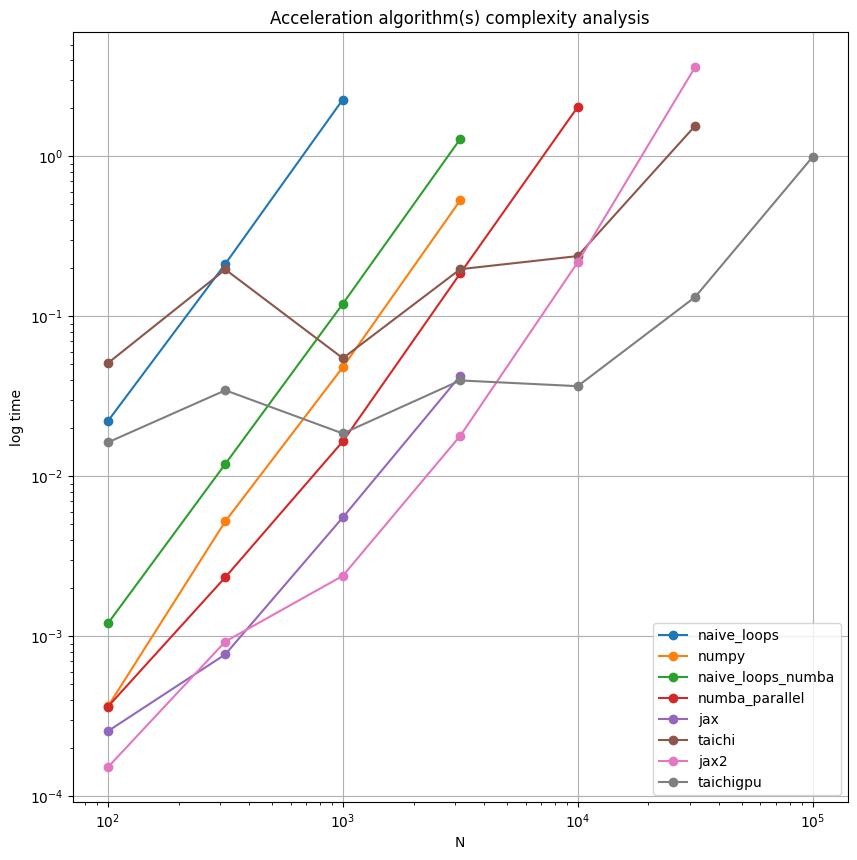

In [92]:
plot_complexity(algorithms_complexity)

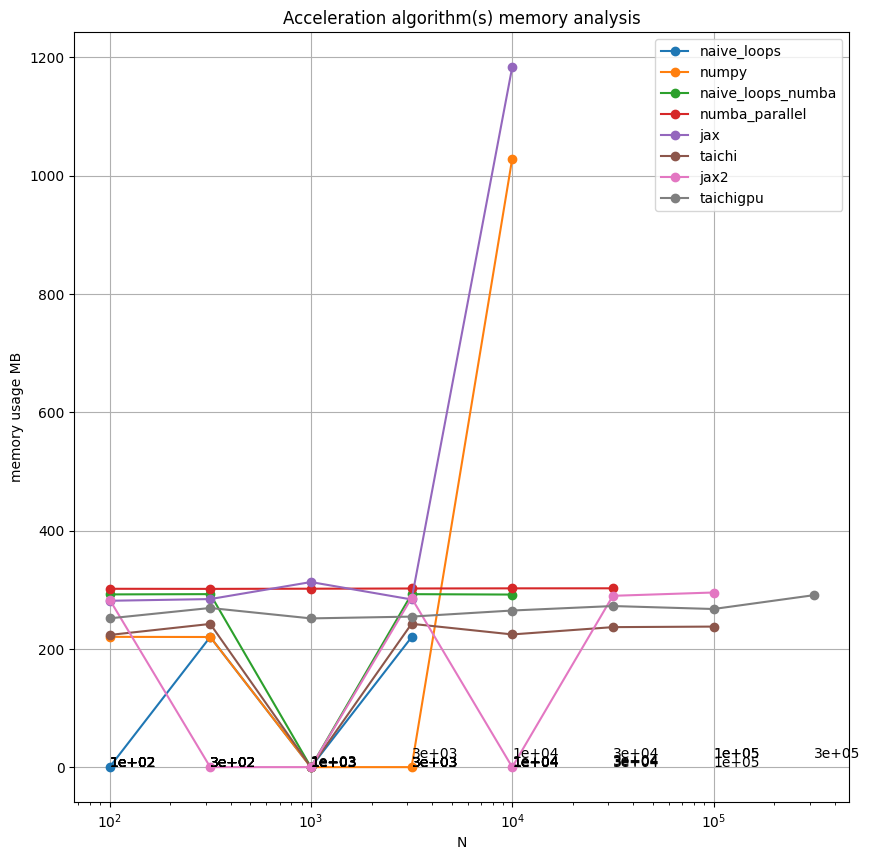

In [93]:
plot_memory(algorithms_complexity)